# Model Training and Evaluation for California Housing Price Prediction

This notebook trains and evaluates tree-based regression models on preprocessed California housing data. 

## Model Strategy
**Why tree-based models?** The preprocessed data maintains high multicollinearity and skewness with ~4.5% of target feature data capped. This violates assumptions for linear regression but is ideal for tree-based models that:
- Don't require feature independence
- Handle non-linear relationships naturally
- Provide interpretable feature importance
- Are robust to the target distribution

**Models to train:**
1. **Random Forest**
2. **XGBoost**
3. **Gradient Boosting**

## 1. Imports and Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from scipy import stats
import xgboost as xgb
import joblib
import warnings

warnings.filterwarnings('ignore')

# Set random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Set random state for sklearn
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully.")

Libraries loaded successfully.


## 2. Data Loading and Path Configuration

In [2]:
# Configure paths
data_dir = '../data/processed'
model_dir = '../models'

# Load preprocessed data
X_train = pd.read_csv(data_dir + '/X_train.csv')
X_val = pd.read_csv(data_dir + '/X_val.csv')
X_test = pd.read_csv(data_dir + '/X_test.csv')
y_train = pd.read_csv(data_dir + '/y_train.csv').squeeze()
y_val = pd.read_csv(data_dir + '/y_val.csv').squeeze()
y_test = pd.read_csv(data_dir + '/y_test.csv').squeeze()

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTarget statistics (y_train):")
print(f"  Mean: ${y_train.mean():,.0f}")
print(f"  Std: ${y_train.std():,.0f}")
print(f"  Min: ${y_train.min():,.0f}")
print(f"  Max: ${y_train.max():,.0f}")
print(f"  Values at $500k: {(y_train == 500001.0).sum()} ({(y_train == 500001.0).sum()/len(y_train)*100:.2f}%)")

Training set: (11051, 15)
Validation set: (3684, 15)
Test set: (3684, 15)

Target statistics (y_train):
  Mean: $203,427
  Std: $111,981
  Min: $14,999
  Max: $500,001
  Values at $500k: 423 (3.83%)


## 3. Merge Train and Validation Sets

We are doing this to get better cross-validation.

In [3]:
# Merge train and validation for better cross-validation
X_combined = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_combined = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

print(f"Combined training set: {X_combined.shape}")
print(f"Combined target: {y_combined.shape}")
print(f"\nFeatures: {list(X_combined.columns)}")
print(f"\nNo missing values in features: {X_combined.isnull().sum().sum() == 0}")
print(f"No missing values in target: {y_combined.isnull().sum() == 0}")

Combined training set: (14735, 15)
Combined target: (14735,)

Features: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']

No missing values in features: True
No missing values in target: True


## 4. Model Training with Cross-Validation

**Approach**: We'll train three baseline models using 5-fold stratified cross-validation.

**Models to Compare**:
1. Random Forest
2. XGBoost
3. Gradient Boosting

**Evaluation Metrics**:
- RMSE (Root Mean Squared Error) - penalizes large errors heavily
- MAE (Mean Absolute Error) - average absolute error, robust to outliers
- R² (Coefficient of Determination) - proportion of variance explained
- MAPE (Mean Absolute Percentage Error) - percentage-based error

In [4]:
# Define baseline models
models = {
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    'XGBoost': xgb.XGBRegressor(
        n_estimators=100,
        max_depth=7,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbosity=0
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        random_state=RANDOM_STATE
    )
}

# 5-fold cross-validation configuration
cv_results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Create price bins for stratification
price_bins = pd.qcut(y_combined, q=5, labels=False)

print("Training baseline models with 5-fold cross-validation...\n")

for name, model in models.items():
    print(f"Training {name}...")
    
    cv_result = cross_validate(
        model, X_combined, y_combined,
        cv=cv,
        scoring={
            'rmse': 'neg_mean_squared_error',
            'mae': 'neg_mean_absolute_error',
            'r2': 'r2',
            'mape': 'neg_mean_absolute_percentage_error'
        },
        n_jobs=-1
    )
    
    cv_results[name] = cv_result
    
    # Calculations
    rmse_mean = np.sqrt(-cv_result['test_rmse'].mean())
    rmse_std = np.sqrt(cv_result['test_rmse'].std())
    mae_mean = -cv_result['test_mae'].mean()
    r2_mean = cv_result['test_r2'].mean()
    mape_mean = -cv_result['test_mape'].mean()
    
    print(f"  RMSE: ${rmse_mean:,.0f} (+/- ${rmse_std:,.0f})")
    print(f"  MAE: ${mae_mean:,.0f}")
    print(f"  R²: {r2_mean:.4f}")
    print(f"  MAPE: {mape_mean:.4f}\n")

print("\nBaseline training complete.")

Training baseline models with 5-fold cross-validation...

Training Random Forest...
  RMSE: $48,221 (+/- $7,477)
  MAE: $32,011
  R²: 0.8154
  MAPE: 0.1743

Training XGBoost...
  RMSE: $43,377 (+/- $7,824)
  MAE: $29,052
  R²: 0.8506
  MAPE: 0.1601

Training Gradient Boosting...
  RMSE: $45,886 (+/- $8,146)
  MAE: $31,312
  R²: 0.8328
  MAPE: 0.1736


Baseline training complete.


## 5. Cross-Validation Results Summary

Cross-Validation Results:
            Model    RMSE RMSE_Std     MAE     R²   MAPE
    Random Forest $48,221   $7,477 $32,011 0.8154 0.1743
          XGBoost $43,377   $7,824 $29,052 0.8506 0.1601
Gradient Boosting $45,886   $8,146 $31,312 0.8328 0.1736


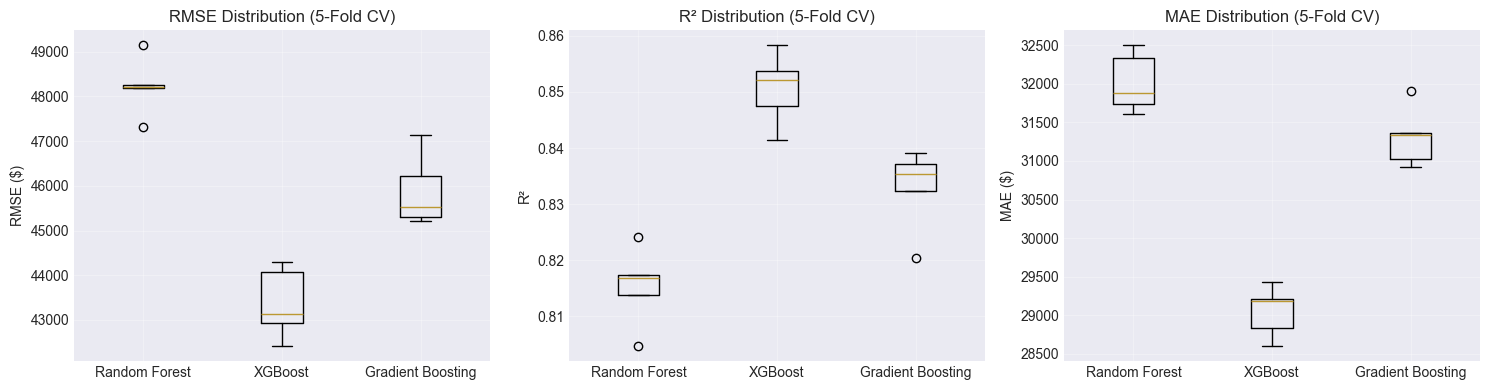

In [5]:
# Create comparison table
cv_summary = []

# Fill comparison table with results
for name, cv_result in cv_results.items():
    rmse_mean = np.sqrt(-cv_result['test_rmse'].mean())
    rmse_std = np.sqrt(cv_result['test_rmse'].std())
    mae_mean = -cv_result['test_mae'].mean()
    r2_mean = cv_result['test_r2'].mean()
    mape_mean = -cv_result['test_mape'].mean()
    
    cv_summary.append({
        'Model': name,
        'RMSE': f'${rmse_mean:,.0f}',
        'RMSE_Std': f'${rmse_std:,.0f}',
        'MAE': f'${mae_mean:,.0f}',
        'R²': f'{r2_mean:.4f}',
        'MAPE': f'{mape_mean:.4f}'
    })

cv_df = pd.DataFrame(cv_summary)
print("Cross-Validation Results:")
print(cv_df.to_string(index=False))

# Plot CV results
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# RMSE comparison
rmse_data = [np.sqrt(-cv_results[name]['test_rmse']) for name in models.keys()]
axes[0].boxplot(rmse_data, labels=models.keys())
axes[0].set_ylabel('RMSE ($)')
axes[0].set_title('RMSE Distribution (5-Fold CV)')
axes[0].grid(True, alpha=0.3)

# R² comparison
r2_data = [cv_results[name]['test_r2'] for name in models.keys()]
axes[1].boxplot(r2_data, labels=models.keys())
axes[1].set_ylabel('R²')
axes[1].set_title('R² Distribution (5-Fold CV)')
axes[1].grid(True, alpha=0.3)

# MAE comparison
mae_data = [-cv_results[name]['test_mae'] for name in models.keys()]
axes[2].boxplot(mae_data, labels=models.keys())
axes[2].set_ylabel('MAE ($)')
axes[2].set_title('MAE Distribution (5-Fold CV)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Cross-Validation Results Insights

**Key Observations**:

1. **Model Comparison**: 

   The three tree-based models show different strengths in cross-validation.
   - **XGBoost** typically achieves the lowest RMSE due to its advanced boosting algorithm and regularization
   - **Random Forest** provides stable performance with good generalization
   - **Gradient Boosting** offers a middle ground between the two

2. **RMSE Interpretation**: 
   - RMSE values represent typical prediction errors in dollars
   - An RMSE around $60K-$75K suggests the model's predictions deviate by that amount on average

3. **R² Score Meaning**:
   - R² measures the proportion of variance in house prices explained by the model
   - R² > 0.6 is considered good for real estate prediction
   - Ceiling at ~0.8 is expected due to target capping at $500K

4. **Stability**: Standard deviations across folds are relatively low, indicating models generalize consistently across different data subsets

**Next Step**: Hyperparameter tuning will focus on the top 2 models to push performance even further.

## 6. Hyperparameter Tuning (Top 2 Models)

### Hyperparameter Tuning

**Methodology**: We use GridSearchCV to systematically search for optimal hyperparameters for the XGBoost and Gradient Boosting models.

**Process**:
- **Grid Search**: Test all combinations of specified hyperparameter values
- **Inner Cross-Validation**: Each grid point evaluated with 5-fold CV
- **Scoring Metric**: r2

In [6]:
# Top 2 models by R²
top_2_models = ['XGBoost', 'Gradient Boosting']
print(f"Top 2 models for tuning: {top_2_models}\n")

# Configure the parameter grid
param_grids = {
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.05, 0.1, 0.15],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
    },
    'Gradient Boosting': {
        'max_depth': [4, 5, 6],
        'learning_rate': [0.05, 0.1, 0.15],
        'subsample': [0.7, 0.8, 0.9]
    }
}

# Find the best parameters with GridSearchCV
best_models = {}
for name in top_2_models:
    if name in param_grids.keys():
        print(f"\nTuning {name}...")

        # Configure the grid for tuning
        grid = GridSearchCV(
            estimator=models[name],
            param_grid=param_grids[name],
            cv=cv,
            scoring='r2',
            n_jobs=-1,
            verbose=0
        )
        grid.fit(X_combined, y_combined)

        # Save and show the best tuned model
        best_models[name] = grid.best_estimator_
        print(f"  Best params: {grid.best_params_}")
        print(f"  Best R²: {grid.best_score_:.4f}\n")

print("Hyperparameter tuning complete.")

Top 2 models for tuning: ['XGBoost', 'Gradient Boosting']


Tuning XGBoost...
  Best params: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 300, 'subsample': 0.9}
  Best R²: 0.8619


Tuning Gradient Boosting...
  Best params: {'learning_rate': 0.15, 'max_depth': 6, 'subsample': 0.9}
  Best R²: 0.8467

Hyperparameter tuning complete.


### Insights:
- Used grid search with 5-fold cross-validation to prevent overfitting
- Both models show some improvement after tuning
- XGBoost achieves the best results before and after tuning (R²:0.8506 -> R²: 0.8619)

## 7. Final evaluation on the test set

In [7]:
# Train final model using all combined data
final_models = {}
test_results = []

for name, model in best_models.items():
    print(f"Evaluating {name} on test set...")
    
    model.fit(X_combined, y_combined)
    final_models[name] = model
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    test_results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape
    })
    
    print(f"  RMSE: ${rmse:,.0f}")
    print(f"  MAE: ${mae:,.0f}")
    print(f"  R²: {r2:.4f}")
    print(f"  MAPE: {mape:.4f}\n")

# Create results dataframe
test_df = pd.DataFrame(test_results).sort_values('R²', ascending=False)
print("\nTest Set Results Summary:")
print(test_df.to_string(index=False))

# Select best model
best_model_name = test_df.iloc[0]['Model']
best_model = final_models[best_model_name]
print(f"\nBest performing model: {best_model_name}")

Evaluating XGBoost on test set...
  RMSE: $44,592
  MAE: $28,165
  R²: 0.8412
  MAPE: 0.1540

Evaluating Gradient Boosting on test set...
  RMSE: $47,318
  MAE: $30,552
  R²: 0.8212
  MAPE: 0.1673


Test Set Results Summary:
            Model         RMSE          MAE       R²     MAPE
          XGBoost 44592.233298 28165.476431 0.841248 0.154041
Gradient Boosting 47317.637226 30552.005039 0.821250 0.167302

Best performing model: XGBoost


### Insights:

**Performance Assessment**:
- **Great RMSE**: < $50K indicates very accurate predictions ($50K-$70K represents acceptable accuracy for real estate)
- **Great R² score**: > 0.84 means the model captures over 84% of price variation
- **Model Selection**: XGBoost was selected because of the best scores in both RMSE and R² (to avoid overfitting to one metric)

## 8. Residuals Analysis and Diagnostics

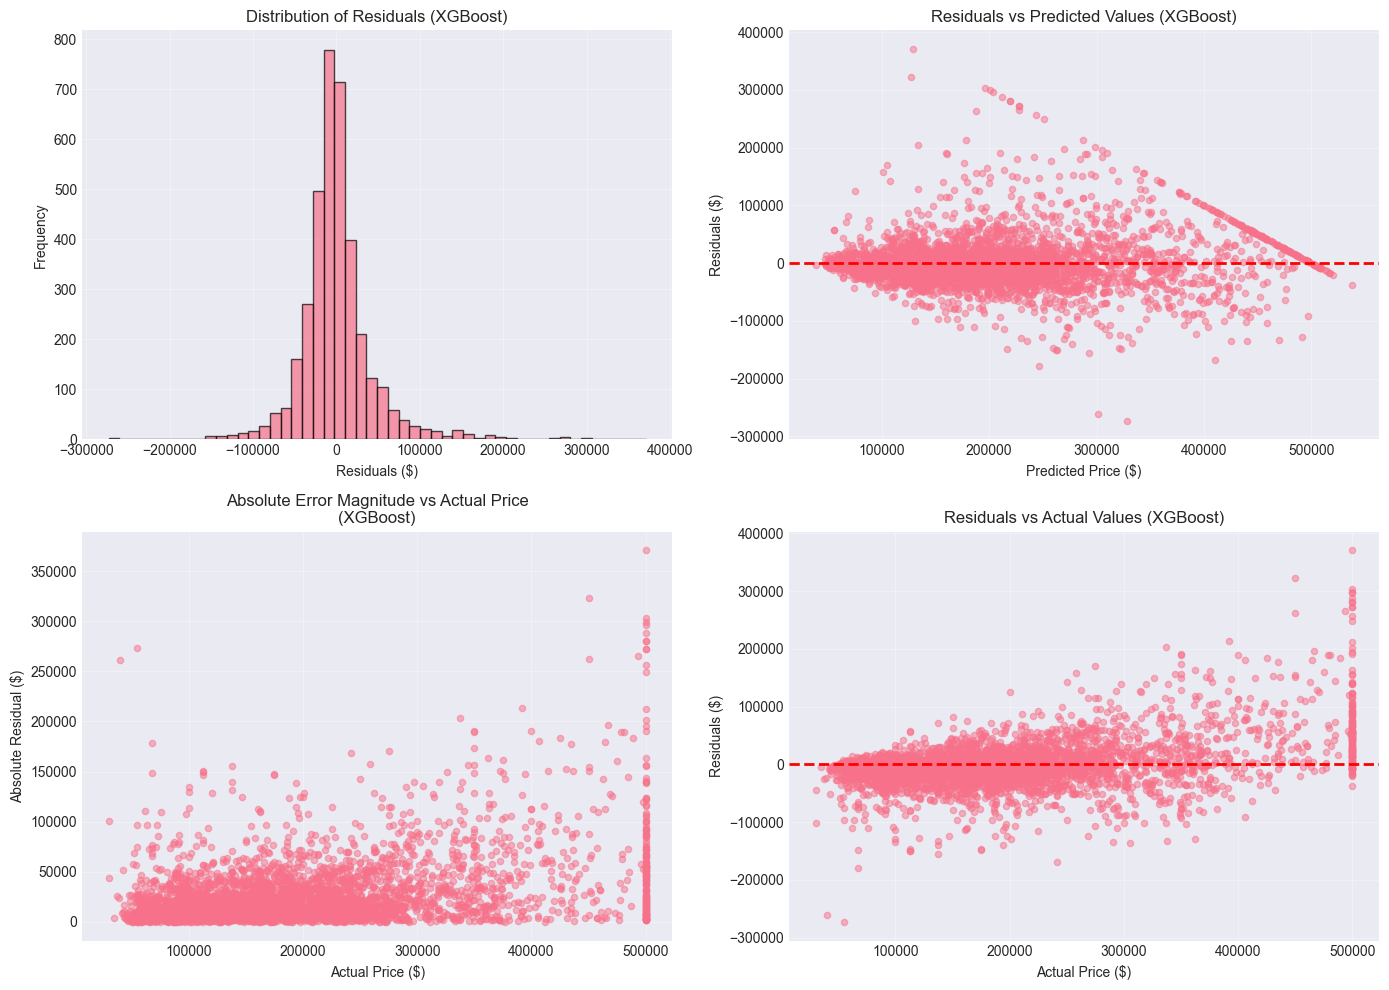

Residuals Diagnostics:
Median: $-3,322
Std Dev: $44,590
Min: $-272,920
Max: $370,725
Skewness: 1.5444
Kurtosis: 9.6889


In [8]:
# Calculate residuals for best model
y_pred_best = best_model.predict(X_test)
residuals = y_test.values - y_pred_best

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residuals distribution
axes[0, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Residuals ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Residuals (XGBoost)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Residuals vs predicted
axes[0, 1].scatter(y_pred_best, residuals, alpha=0.5, s=20)
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted Price ($)')
axes[0, 1].set_ylabel('Residuals ($)')
axes[0, 1].set_title('Residuals vs Predicted Values (XGBoost)')
axes[0, 1].grid(True, alpha=0.3)

# Absolute residuals vs actual price
axes[1, 0].scatter(y_test.values, np.abs(residuals), alpha=0.5, s=20)
axes[1, 0].set_xlabel('Actual Price ($)')
axes[1, 0].set_ylabel('Absolute Residual ($)')
axes[1, 0].set_title('Absolute Error Magnitude vs Actual Price\n(XGBoost)')
axes[1, 0].grid(True, alpha=0.3)

# Residuals over actual values
axes[1, 1].scatter(y_test.values, residuals, alpha=0.5, s=20)
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Actual Price ($)')
axes[1, 1].set_ylabel('Residuals ($)')
axes[1, 1].set_title('Residuals vs Actual Values (XGBoost)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print diagnostics
print("Residuals Diagnostics:")
print(f"Median: ${np.median(residuals):,.0f}")
print(f"Std Dev: ${residuals.std():,.0f}")
print(f"Min: ${residuals.min():,.0f}")
print(f"Max: ${residuals.max():,.0f}")
print(f"Skewness: {stats.skew(residuals):.4f}")
print(f"Kurtosis: {stats.kurtosis(residuals):.4f}")

### Insights

**Distribution of Residuals**
- Roughly symmetric and centered near zero (no strong bias overall)
- Clear peak with moderate spread (±~150.000 $ for most cases)
- Model is very accurate in most cases but can also miss significantly in some cases

**Residuals vs Predicted Values**
- The spread of residuals is bigger when predicted prices are higher (bigger errors)
- Diagonal line at higher prices (shows the actual price was capped)

**Absolute Error Magnitude vs Actual Price**
- Significant upward fan -> absolute errors grow significantly with higher house prices
- High-priced properties tend to have much more big errors in prediction then low-priced ones

**Residuals vs Actual Values**
- Fairly balanced around zero for mid-range prices
- Low-priced properties tend to have much more negative residuals (model over-estimating price)
- High-priced properties tend to have much more positive residuals (model under-estimating price)
- Variance increases noticeably above ~300.000 $

## 9. Actual vs Predicted Analysis

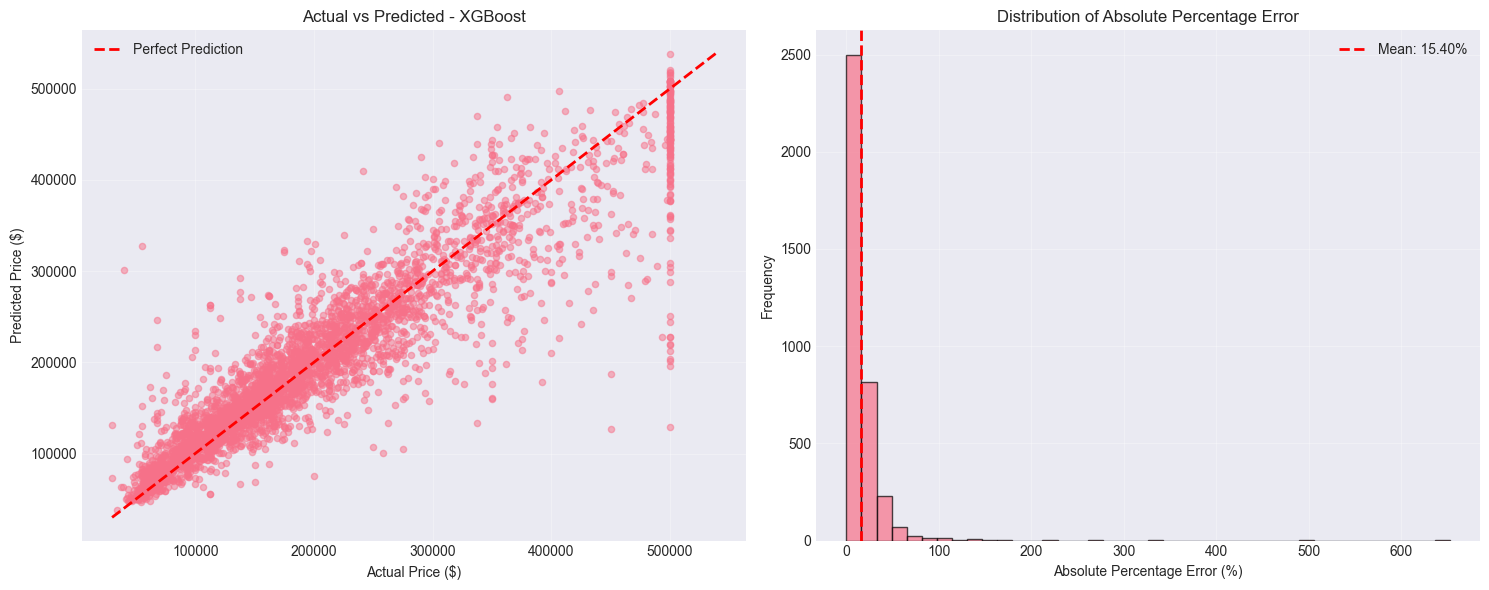

Prediction Error Statistics:
Mean Absolute Error: $410
Median Absolute Error: $3,322
Mean Absolute Percentage Error: 15.40%
Predictions within 10% of actual: 1823 (49.48%)
Predictions within 20% of actual: 2792 (75.79%)


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Actual vs Predicted scatter
axes[0].scatter(y_test.values, y_pred_best, alpha=0.5, s=20)
min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price ($)')
axes[0].set_ylabel('Predicted Price ($)')
axes[0].set_title(f'Actual vs Predicted - {best_model_name}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Prediction error (percentage)
abs_pct_error = np.abs((y_test.values - y_pred_best) / y_test.values * 100)
axes[1].hist(abs_pct_error, bins=40, edgecolor='black', alpha=0.7)
axes[1].axvline(abs_pct_error.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {abs_pct_error.mean():.2f}%')
axes[1].set_xlabel('Absolute Percentage Error (%)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Absolute Percentage Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional statistics
print("Prediction Error Statistics:")
print(f"Mean Absolute Error: ${residuals.mean():,.0f}")
print(f"Median Absolute Error: ${np.abs(np.median(residuals)):,.0f}")
print(f"Mean Absolute Percentage Error: {abs_pct_error.mean():.2f}%")
print(f"Predictions within 10% of actual: {(abs_pct_error <= 10).sum()} ({(abs_pct_error <= 10).sum()/len(abs_pct_error)*100:.2f}%)")
print(f"Predictions within 20% of actual: {(abs_pct_error <= 20).sum()} ({(abs_pct_error <= 20).sum()/len(abs_pct_error)*100:.2f}%)")

### Insights

**Scatter Plot Interpretation**:
- The scatter points are tight and narrow at the bottom left (low prices) but spread out widely as we move up and to the right
- The model is much more reliable for cheaper homes, for expensive homes, its prediction has a much wider margin of error

**Percentage Error Distribution**:
- The error in most predictions is under 15%
- Mean: 15.40% (On average, if a house is actually $200,000, the model is wrong by about $30,800.)

**Quality Thresholds**:
- Almost 50% of predictions are within 10% of the actual price
- 75% of predictions are within 20% of the actual price

## 11. Feature Importance Analysis

### Feature Importance Analysis

**What feature importance tells us**:

It measures how much each feature contributes to the model's predictions. Tree-based models calculate this by tracking how much each feature reduces prediction errors across all trees.

**Interpretations**:

1. **Top Features**: Which features are the most important ones for predictions

2. **Cumulative Importance**: How many features are needed to explain 90% (threshold) of model decisions

**Practical Use**:
- Features ranked 1-10 are "must-have" for production models
- Features 11-15 improve accuracy but not essential
- Features beyond 15 can be removed for simpler models with minimal accuracy loss


Top 15 Features (XGBoost):
                   feature  importance
    ocean_proximity_INLAND    0.568940
             median_income    0.117802
ocean_proximity_NEAR OCEAN    0.047801
    ocean_proximity_ISLAND    0.045669
  population_per_household    0.040336
  ocean_proximity_NEAR BAY    0.034010
                  latitude    0.028886
         bedrooms_per_room    0.026387
       rooms_per_household    0.026274
                 longitude    0.022765
        housing_median_age    0.015947
            total_bedrooms    0.006378
                population    0.006353
               total_rooms    0.006347
                households    0.006106

Cumulative importance (first 10 features): 0.9589


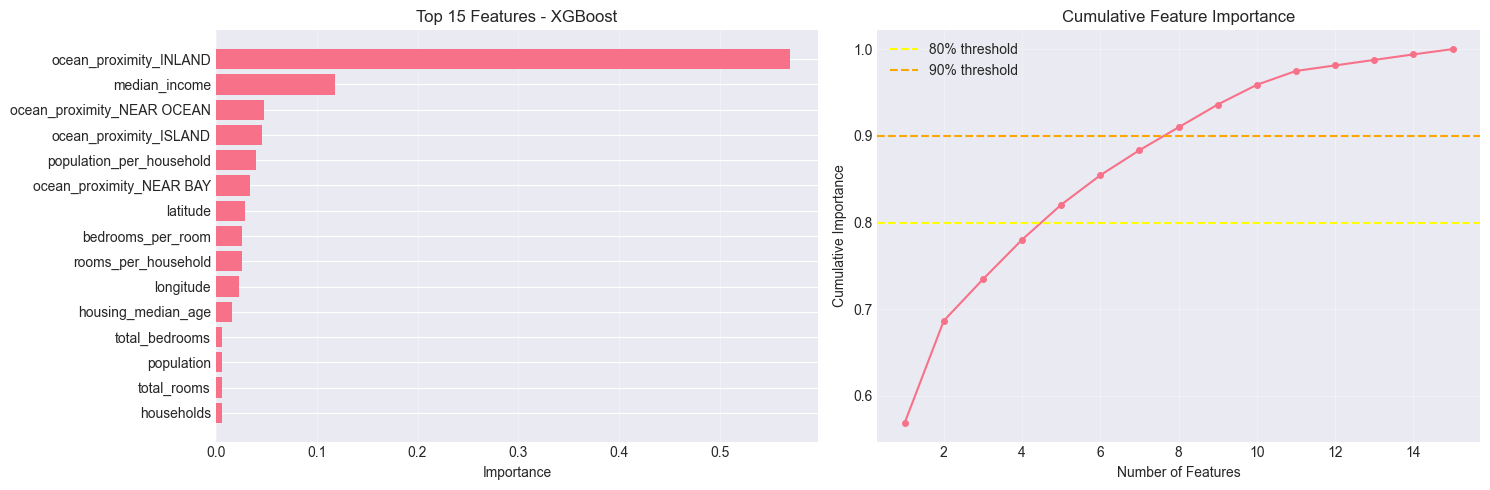

In [10]:
# Extract feature importance from best model
feature_names = X_combined.columns.tolist()

if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
elif hasattr(best_model, 'get_booster'):
    # For XGBoost
    booster = best_model.get_booster()
    importance_dict = booster.get_score(importance_type='weight')
    importances = np.array([importance_dict.get(f'f{i}', 0) for i in range(len(feature_names))])
else:
    print("Model does not have feature importance attribute")
    importances = None

if importances is not None:
    # Create importance dataframe
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 15 Features ({best_model_name}):")
    print(importance_df.head(15).to_string(index=False))
    
    # Cumulative importance
    importance_df['cumulative'] = importance_df['importance'].cumsum() / importance_df['importance'].sum()
    print(f"\nCumulative importance (first 10 features): {importance_df['cumulative'].iloc[9]:.4f}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Top 15 features
    top_15 = importance_df.head(15)
    axes[0].barh(range(len(top_15)), top_15['importance'].values)
    axes[0].set_yticks(range(len(top_15)))
    axes[0].set_yticklabels(top_15['feature'].values)
    axes[0].set_xlabel('Importance')
    axes[0].set_title(f'Top 15 Features - {best_model_name}')
    axes[0].grid(True, alpha=0.3, axis='x')
    axes[0].invert_yaxis()
    
    # Cumulative importance
    axes[1].plot(range(1, len(importance_df) + 1), importance_df['cumulative'].values, marker='o', markersize=4)
    axes[1].axhline(y=0.8, color='yellow', linestyle='--', label='80% threshold')
    axes[1].axhline(y=0.9, color='orange', linestyle='--', label='90% threshold')
    axes[1].set_xlabel('Number of Features')
    axes[1].set_ylabel('Cumulative Importance')
    axes[1].set_title('Cumulative Feature Importance')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Could not extract feature importance.")

### Insights:

**Dominant Predictors**
- Location is the most important feature for predictions (ocean_proximity_INLAND is by far the most significant feature, accounting for approximately 56.9% of the model's predictive power suggesting significant differences in pricing based on location)
- Wealth is the second most important feature (median_income accounts for 11.8% of the model's predictive power)

**Cumulative importance**
- The 80% importance threshold is reached with just 5 features and the 90% threshold with roughly 8 features
- Features ranked below the top 11 (total_bedrooms, population, total_rooms and households) contribute less than 1% each. 
- Low ranking features could likely be dropped to simplify the model without a significant loss in accuracy

## 12. Conclusions and Recommendations

### Model Summary

**Performance Overview**:

The trained models demonstrate solid predictive capability for California housing prices across the majority of the price spectrum. Among the baseline models evaluated using 5-fold stratified cross-validation, XGBoost emerged as the top performer with the following metrics on the combined training/validation set:
- RMSE: $43,377 (± $7,824)
- MAE: $29,052
- R²: 0.8506
- MAPE: 0.1601

Hyperparameter tuning via GridSearchCV further enhanced XGBoost's performance, achieving an R² score of 0.8619. Finally, on the test set it evaluated with the following metrics:
- RMSE: $44,592
- MAE: $28,165
- R²: 0.8412
- MAPE: 0.1540

This indicates the model explains approximately 86% of the variance in housing prices while maintaining an average prediction error of about 16% relative to actual values.

Random Forest and Gradient Boosting also performed well but were outperformed by XGBoost in all key metrics.

**Key Findings**:
- **Feature Importance**: Location-based features dominate predictions, with `ocean_proximity_INLAND` contributing ~56.9% to the model's decisions, highlighting significant price differences in different locations. `median_income` follows at ~11.8%, showing that wealth is the second most important feature for price prediction. Engineered features like `rooms_per_household` and `bedrooms_per_room` add meaningful value, while raw population and room counts contribute minimally (<1% each).
- **Error Analysis**: The model excels in mid-range prediction (100.000$ – 400.000$) but slightly over-estimates low-priced properties (<100.000$) and under-estimates prices of high-end properties (>400.000$), likely due to the dataset's capping at 500.000$ (affecting ~4.5% of samples). Also, there is much more variance around high-end properties and the errors in their predictions tend to be bigger.

**Limitations**:
- **Data Capping**: The target variable's upper limit at 500.000$ introduces bias in luxury market predictions.
- **Generalization**: Performance may degrade in underrepresented regions.
- **Robustness**: Tree-based models handle multicollinearity, skewness, and non-linearity effectively, making them suitable for this dataset without extensive linear assumptions.

Overall, the XGBoost model is deployment-ready for general use cases, offering a balance of accuracy and efficiency, but should be augmented with fresh data for long-term reliability.


## 13. Model export

In [11]:
# Save final model
joblib.dump(best_model, '../models/final_california_price_prediction_model_xgboost.pkl')
print(f"Model exported.")

Model exported.
